In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


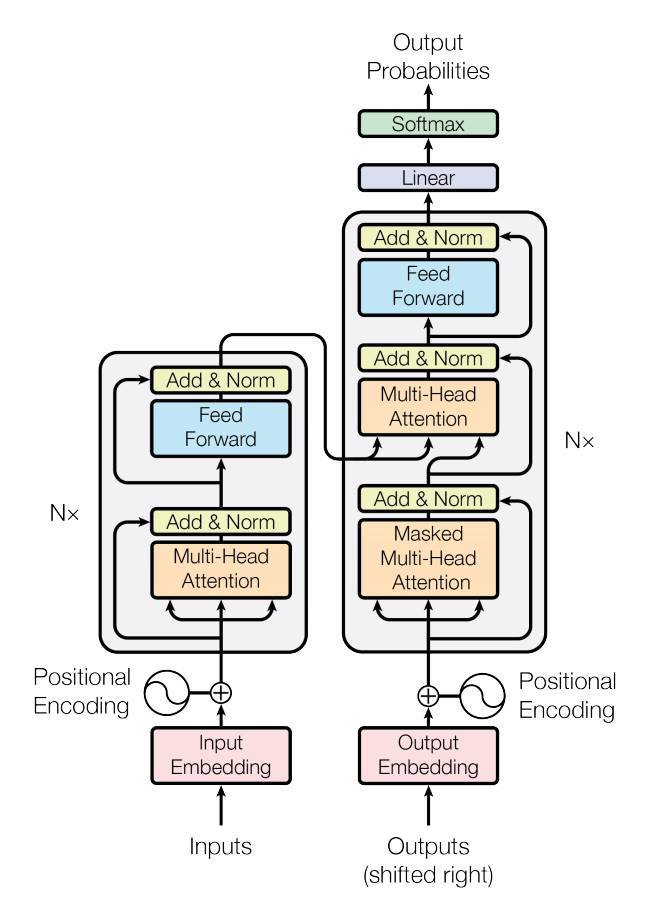

## Define the model

In this tutorial, we train a nn.TransformerEncoder model on a language modeling task. The language modeling task is to assign a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words. A sequence of tokens are passed to the embedding layer first, followed by a positional encoding layer to account for the order of the word (see the next paragraph for more details). The nn.TransformerEncoder consists of multiple layers of nn.TransformerEncoderLayer. Along with the input sequence, a square attention mask is required because the self-attention layers in nn.TransformerEncoder are only allowed to attend the earlier positions in the sequence. For the language modeling task, any tokens on the future positions should be masked. To produce a probability distribution over output words, the output of the nn.TransformerEncoder model is passed through a linear layer followed by a log-softmax function

In [9]:
import math
from typing import Tuple

import torch 
from torch import nn, Tensor 
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset 

class TransformerModel(nn.Module):
  def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, nlayers: int, dropout: float = 0.5):
    super().__init__()
    self.model_type = "Transformer"
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
    self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
    self.encoder = nn.Embedding(ntoken, d_model)
    self.d_model = d_model
    self.decoder = nn.Linear(d_model, ntoken)

    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.encoder.weight.data.uniform_(-initrange, initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

  def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
    """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
    """
    src = self.encoder(src) * math.sqrt(self.d_model)
    src = self.pos_encoder(src)
    output = self.transformer_encoder(src, src_mask)
    output = self.decoder(output)
    return output 

def generate_square_subsequent_mask(sz: int) -> Tensor:
  """Generates an upper-triangular matrix of -inf, with zeros on diag."""
  return torch.triu(torch.ones(sz, sz) * float("-inf"), diagonal=1)


PositionalEncoding module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [3]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer("pe", pe)

  def forward(self, x: Tensor) -> Tensor:
    """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

# Load and batch data

This tutorial uses torchtext to generate Wikitext-2 dataset. To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data. %%

In [4]:
!pip install torchdata==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.6 MB/s 
     |████████████████████████████████| 140 kB 67.0 MB/s 
     |████████████████████████████████| 127 kB 63.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


The vocab object is built based on the train dataset and is used to numericalize tokens into tensors. Wikitext-2 represents rare tokens as <unk>.

Given a 1-D vector of sequential data, batchify() arranges the data into batch_size columns. If the data does not divide evenly into batch_size columns, then the data is trimmed to fit. For instance, with the alphabet as the data (total length of 26) and batch_size=4, we would divide the alphabet into 4 sequences of length 6:

[A​B​C​…​X​Y​Z​]⇒⎣
⎡​⎣
⎡​ABCDEF​⎦
⎤​​⎣
⎡​GHIJKL​⎦
⎤​​⎣
⎡​MNOPQR​⎦
⎤​​⎣
⎡​STUVWX​⎦
⎤​​⎦
⎤​

Batching enables more parallelizable processing. However, batching means that the model treats each column independently; for example, the dependence of G and F can not be learned in the example above.

In [5]:
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split="train")
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
  """Converts raw text into a flat Tensor."""
  data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data: Tensor, bsz: int) -> Tensor:
  """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
  """
  seq_len = data.size(0) // bsz 
  data = data[:seq_len * bsz]
  data = data.view(bsz, seq_len).t().contiguous()
  return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size) # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

## Functions to generate input and target sequence

get_batch() generates a pair of input-target sequences for the transformer model. It subdivides the source data into chunks of length bptt. For the language modeling task, the model needs the following words as Target. For example, with a bptt value of 2, we’d get the following two Variables for i = 0:

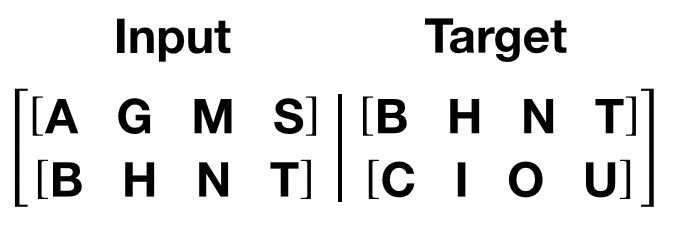

It should be noted that the chunks are along dimension 0, consistent with the S dimension in the Transformer model. The batch dimension N is along dimension 1.

In [7]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
  """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
  """
  seq_len = min(bptt, len(source) - 1 - i)
  data = source[i: i+seq_len]
  target = source[i+1: i+1+seq_len].reshape(-1)
  return data, target

## Initiate an instance

The model hyperparameters are defined below. The vocab size is equal to the length of the vocab object.

In [8]:
ntokens = len(vocab) # size of vocabulary
emsize = 200 # embedding dimension
d_hid = 200 # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # number of heads in nn.MultiheadAttention
dropout = 0.2 # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

## Run the model

We use CrossEntropyLoss with the SGD (stochastic gradient descent) optimizer. The learning rate is initially set to 5.0 and follows a StepLR schedule. During training, we use nn.utils.clip_grad_norm_ to prevent gradients from exploding.

In [10]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
  model.train()  # turn on train mode
  total_loss = 0.
  log_interval = 200
  start_time = time.time()
  src_mask = generate_square_subsequent_mask(bptt).to(device)

  num_batches = len(train_data) // bptt
  for batch, i in enumerate(range(0, train_data.size(0) -1, bptt)):
    data, targets = get_batch(train_data, i)
    seq_len = data.size(0)
    if seq_len != bptt:
      src_mask = src_mask[:seq_len, :seq_len]
    output = model(data, src_mask)
    loss = criterion(output.view(-1, ntokens), targets)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    total_loss += loss.item()
    if batch % log_interval == 0 and batch > 0:
      lr = scheduler.get_last_lr()[0]
      ms_per_batch = (time.time() - start_time) * 1000 / log_interval
      cur_loss = total_loss / log_interval
      ppl = math.exp(cur_loss)
      print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
      total_loss = 0
      start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
  model.eval() # turn on evaluation mode
  total_loss = 0
  src_mask = generate_square_subsequent_mask(bptt).to(device)
  with torch.no_grad():
    for i in range(0, eval_data.size(0) - 1, bptt):
      data, targets = get_batch(eval_data, i)
      seq_len = data.size(0)
      if seq_len != bptt:
        src_mask = src_mask[:seq_len, :seq_len]
      output = model(data, src_mask)
      output_flat = output.view(-1, ntokens)
      total_loss += seq_len * criterion(output_flat, targets).item()
  return total_loss / (len(eval_data) - 1)
    

Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

In [11]:
best_val_loss = float("inf")
epochs = 3
best_model = None

for epoch in range(1, epochs + 1):
  epoch_start_time = time.time()
  train(model)
  val_loss = evaluate(model, val_data)
  val_ppl = math.exp(val_loss)
  elapsed = time.time() - epoch_start_time
  print('-' * 89)
  print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
  print('-' * 89)

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = copy.deepcopy(model)

  scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 27.48 | loss  8.23 | ppl  3746.44
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 15.28 | loss  6.91 | ppl  1001.92
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 15.36 | loss  6.47 | ppl   648.41
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 15.50 | loss  6.32 | ppl   555.60
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 15.48 | loss  6.20 | ppl   493.08
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 15.63 | loss  6.16 | ppl   473.97
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 15.68 | loss  6.12 | ppl   455.87
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 15.72 | loss  6.12 | ppl   453.11
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 15.82 | loss  6.03 | ppl   414.28
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 15.82 | loss  6.03 | ppl   413.74
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 15.88 | loss  5.90 | ppl   364.39
| epoch   1 |  2400/ 

## Evaluate the best model on the test dataset

In [12]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.52 | test ppl   250.10
